# Display of products and saving in fits format using api.plot_tools

This notebooks documents the functinality of `oda_api.plot_tools` to visualize images, spectra, and light curves.

Each of these products can also be saved in `fits` format. The user can add systematic uncertainty to the light curves and spectra; the latter can also be grouped for a quicker fit at the moment of saving files.

Utilities to extract a manipulate the image catalog are also given in order to optimize spectral and 
light curve extraction.


*author: Carlo Ferrigno (carlo.ferrigno@unige.ch)*

In [1]:
source_name="GX 1+4"
tstart='2019-01-01T00:00:00'
tstop='2019-03-31T23:59:59'
n_scw_ima = 10
n_scw_spec_lc = 20
radius_isgri = 8
radius_j1 = 3
run_spec=True
make_image=True
make_j1_image=True
make_lc=True
run_lc_jemx1 = True
e_min = 28.
e_max = 50.
e_min_j1 = 3.
e_max_j1 = 20.
use_token = False

In [2]:
from importlib import reload

In [3]:
from importlib import reload

import oda_api
import oda_api.token
import logging

#logging.getLogger().setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.INFO) #for more verbose logging

logging.getLogger('').addHandler(logging.StreamHandler()) 

## Get the token (if available)

In [4]:
import oda_api.token

if use_token:
    token = oda_api.token.discover_token()
    oda_api.token.decode_oda_token(token)
else:
    token = None



In [5]:
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord


simbad = Simbad.query_object(source_name)
coord = SkyCoord(simbad['RA'], simbad['DEC'], unit=[u.hour, u.deg])

ra = coord.ra.deg
dec = coord.dec.deg

print("Coordinates for %s are RA=%.4f, Dec=%.4f"%(source_name,ra,dec ) )

Coordinates for GX 1+4 are RA=263.0090, Dec=-24.7456


## We make an image

In [6]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"detection_threshold": "7.0",
"instrument": "isgri",
"integral_data_rights": "public",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_image",
"product_type": "Real",

}

In [7]:
import oda_api.api
host="https://www.astro.unige.ch/mmoda/dispatch-data"

disp = oda_api.api.DispatcherAPI(url=host)

if make_image:    
    isgri_image=disp.get_product(**par_dict)

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/oda_api/api.py:922: UserWarning: 
----------------------------------------------------------------------------
the parameter: oda_api_version   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'detection_threshold', 'image_scale_min', 'image_scale_max']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting fo

In [8]:
%matplotlib notebook

## We can look at the image and use sliders to adjust the contrast

In [9]:
isgri_image.mosaic_image_0_mosaic

<IPython.core.display.Javascript object>


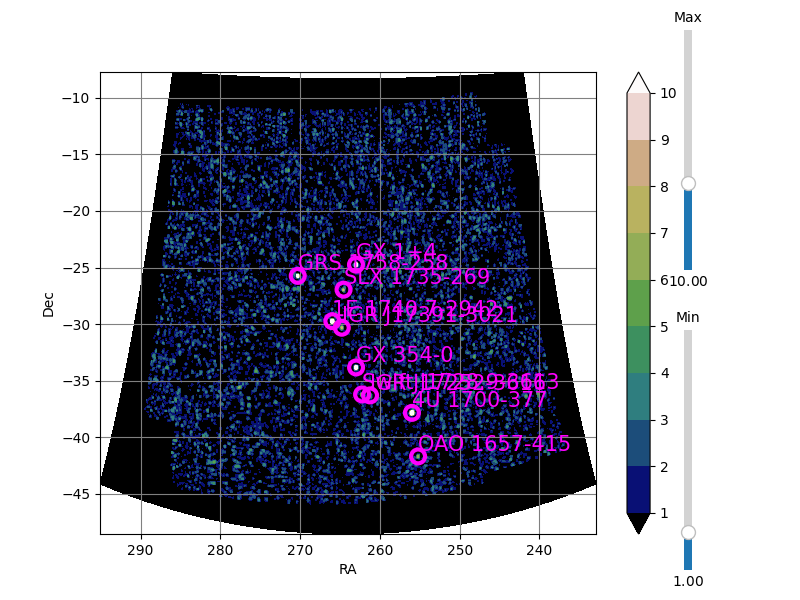

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58526.447905 from DATE-OBS.
Set MJD-END to 58557.991262 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58526.447905 from DATE-OBS.
Set MJD-END to 58557.991262 from DATE-END'.


In [10]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image)
_=image.show()

## We get the catalog from the image to be used in the light curves and spectra
- note that we can add an object of interest in the case it is not detected in the mosaic and to assign a FLAG=1
- Coordinates are derived from Simbad, or dirctly given as objects_of_interest=[(source_name, coord)], see above for the coord definition

In [11]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image)
catalog_string = image.extract_catalog_string_from_image(objects_of_interest=[source_name])

Elaborating object of interest: GX 1+4 263.008977 -24.745590
RA=263.009 Dec=-24.7456
Found GX 1+4 in catalog


In [12]:
catalog_string

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[3, 20, 46, 47, 54, 128, 150, 245, 262, 277], ["1E 1740.7-2942", "4U 1700-377", "GRS 1758-258", "GX 1+4", "GX 354-0", "IGR J17252-3616", "IGR J17391-3021", "OAO 1657-415", "SLX 1735-269", "Swift J1728.9-3613"], [37.77094268798828, 35.79611587524414, 23.00543785095215, 38.75000762939453, 33.56985092163086, 7.799460411071777, 8.421113014221191, 8.176356315612793, 8.559125900268555, 9.243657112121582], [265.9716796875, 255.99024963378906, 270.3056640625, 263.0048828125, 262.99346923828125, 261.2395935058594, 264.7843322753906, 255.21841430664062, 264.5645751953125, 262.23870849609375], [-29.741472244262695, -37.84401321411133, -25.738916397094727, -24.74757957458496, -33.83165740966797, -36.302249908447266, -30.321863174438477, -41.690799713134766, -26.958356857299805, -36.21576690673828], [-32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768], [2, 2, 2, 2, 2, 1, 2, 2, 2, 2], [0, 0, 0, 1, 0, 0, 0

## We make an image for JEM-X1 and visualize it

In [13]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"jemx_num": "1",
"osa_version": "OSA11.1",
"detection_threshold": "7.0",
"integral_data_rights": "public",
"instrument": "jemx",
"product": "jemx_image",
"product_type": "Real",
"off_line": "False",
}

In [14]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)

if make_j1_image:    
    j1_image=disp.get_product(**par_dict)        

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2021-12-08 17:10:57), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: NR8H0O1IZ3Q2WYNO job: d6715d9b2bd2bc2f

... query status prepared => done
... assigned job id: d6715d9b2bd2bc2f
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


<IPython.core.display.Javascript object>


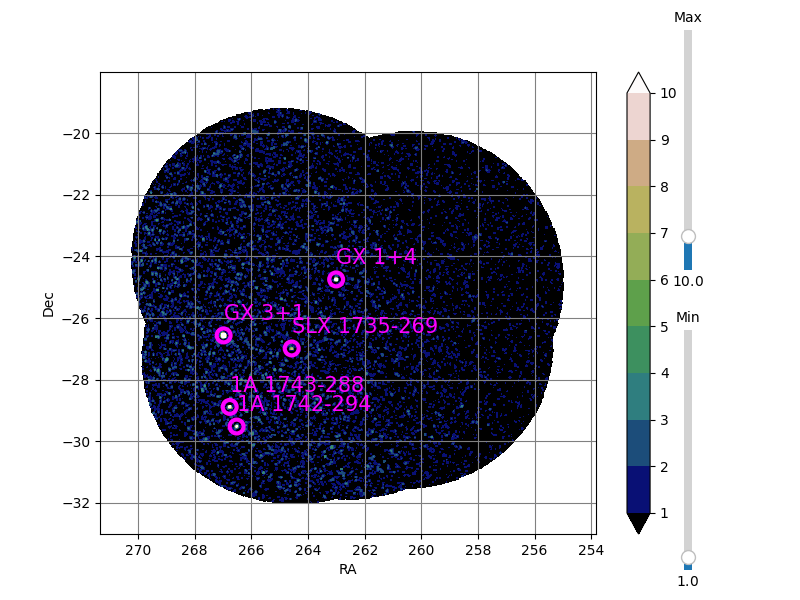

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.


In [15]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
_=image.show()

## We can write the image in a fits file

In [16]:
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
image.write_fits('J1_')

## We can make a light curve and simply visualize it
(note that we use the catalog extracted from the image)

In [17]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"osa_version": "OSA11.1",
"product": "isgri_lc",
"product_type": "Real",
"time_bin": "1000",
"token": token,
"selected_catalog": catalog_string
}


In [18]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)

if make_lc:
    combined_data=disp.get_product(**par_dict)                

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2021-12-08 17:11:17), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: DBOBBVQP7M5VX2MX job: 615de97eb762dbed

... query status prepared => done
... assigned job id: 615de97eb762dbed
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


<IPython.core.display.Javascript object>


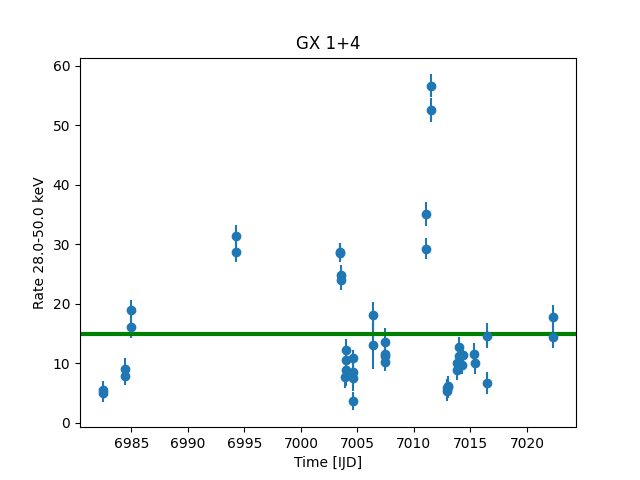

In [19]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
lc = oda_api.plot_tools.OdaLightCurve(combined_data)
_=lc.show(source_name)

## If no source is given all light curves are shown

<IPython.core.display.Javascript object>


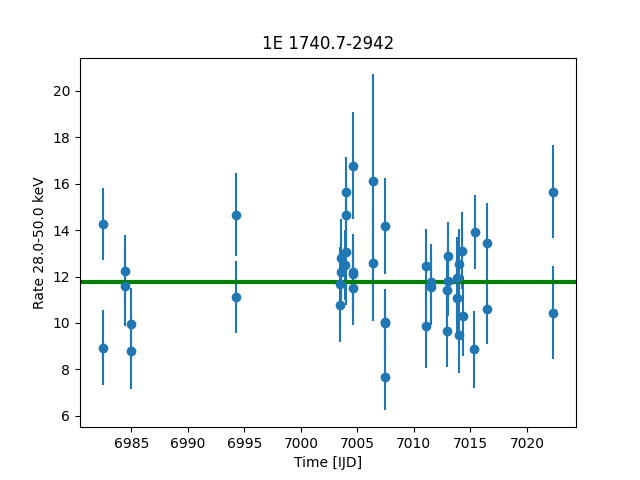

<IPython.core.display.Javascript object>


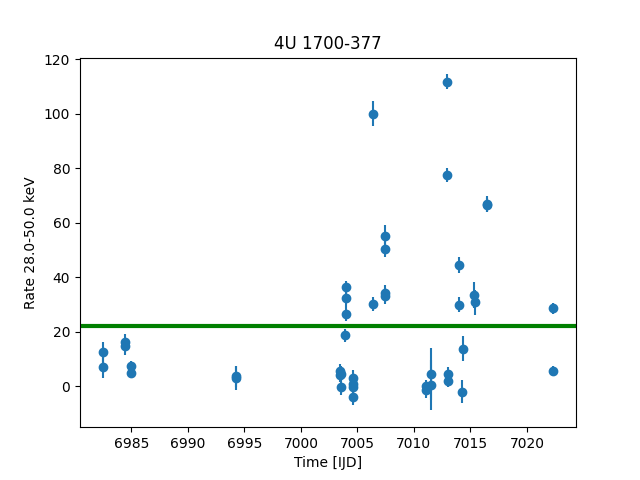

<IPython.core.display.Javascript object>


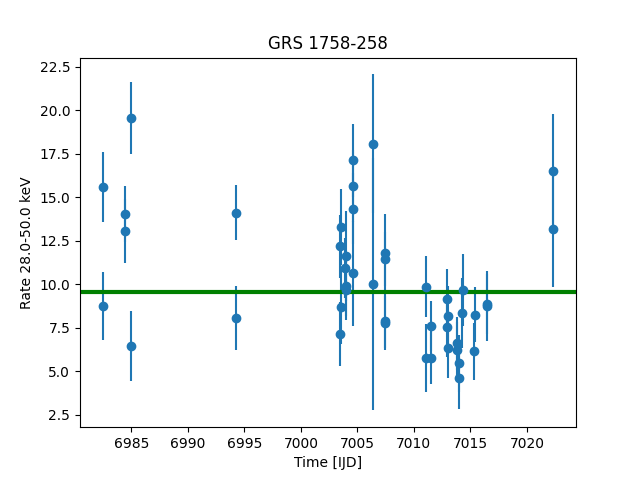

<IPython.core.display.Javascript object>


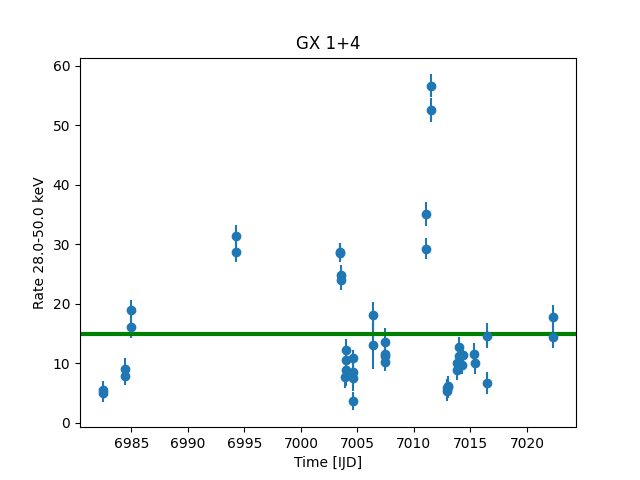

<IPython.core.display.Javascript object>


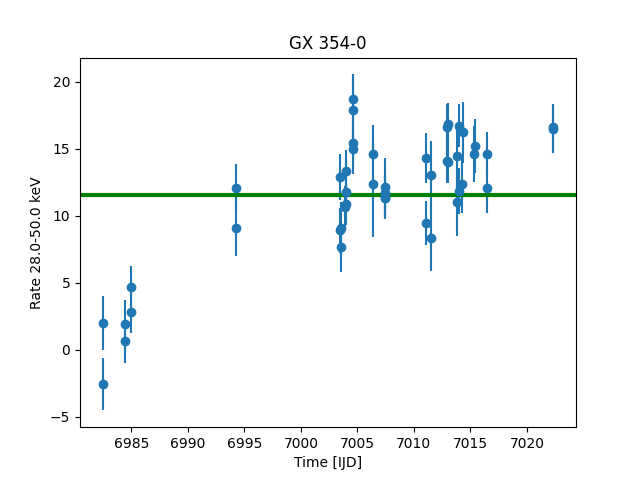

<IPython.core.display.Javascript object>


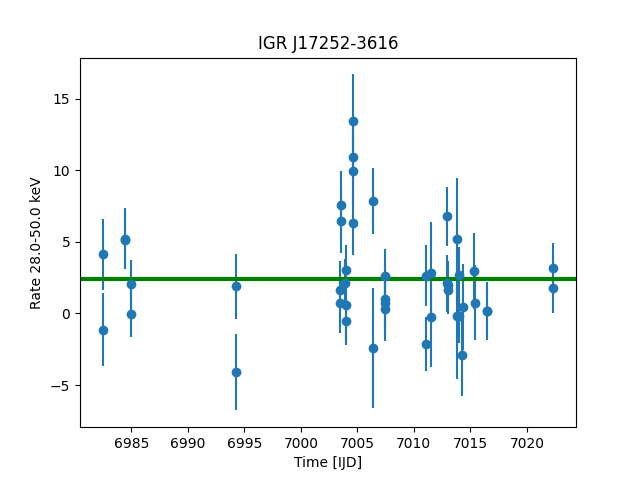

<IPython.core.display.Javascript object>


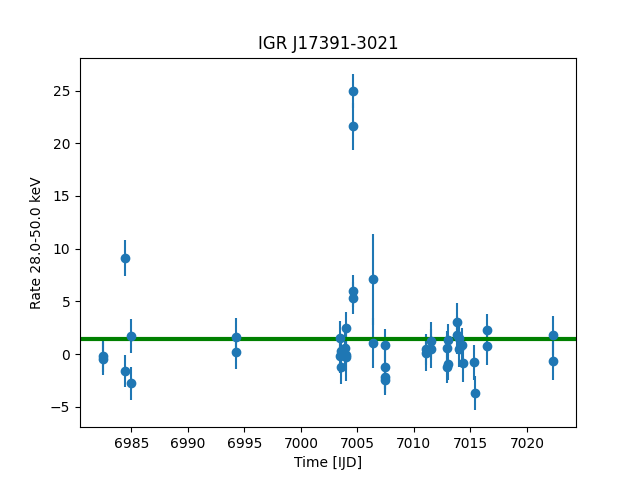

<IPython.core.display.Javascript object>


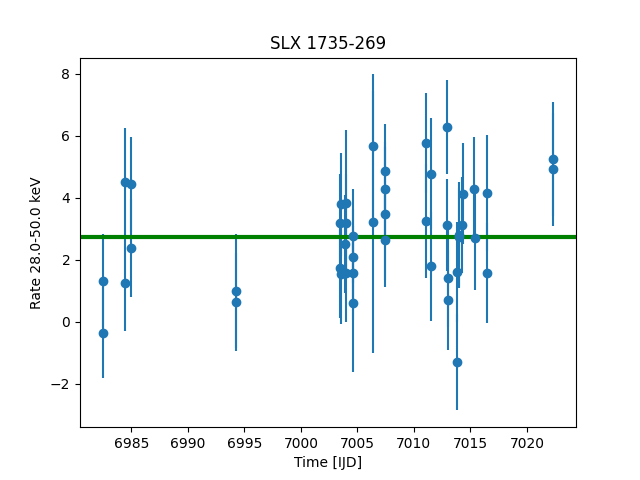

<IPython.core.display.Javascript object>


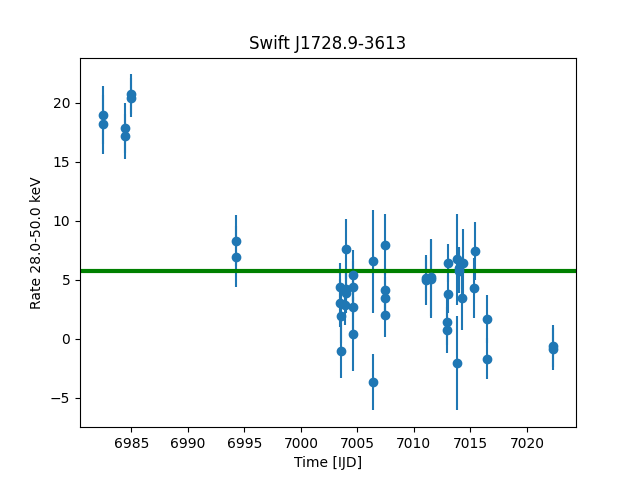

<IPython.core.display.Javascript object>


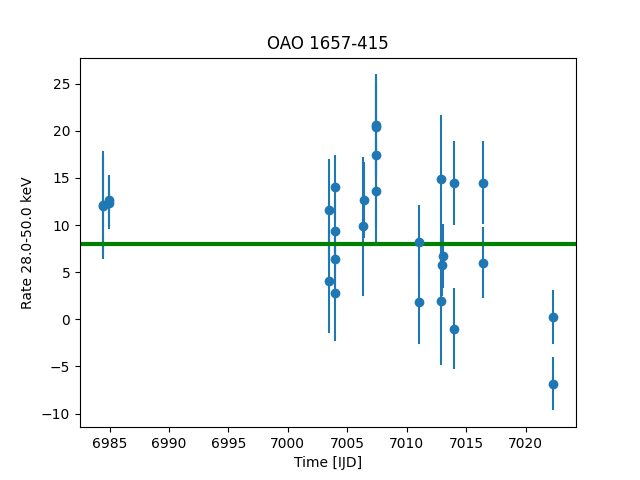

In [20]:
_=lc.show()

## We can search for thermonuclear bursts in the JEM-X light curve

In [21]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_lc",
"product_type": "Real",
"selected_catalog": catalog_string,
"src_name": "1E 1740.7-2942",
"time_bin": "4",
"token": token}

In [22]:
if run_lc_jemx1 :
    
    disp = oda_api.api.DispatcherAPI(url=host)
        
    combined_data=disp.get_product(**par_dict)


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/oda_api/api.py:922: UserWarning: 
----------------------------------------------------------------------------
the parameter: oda_api_version   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'jemx_num', 'E1_keV', 'E2_keV', 'time_bin']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2021-12-08 1

## Advanced display of light curves
- with the keyword ng_sig_limit you can select the limit for variability in standard deviations
- with the keyword find_excesses you can find points above this limit, which can be useful to find thermonuclear bursts 

<IPython.core.display.Javascript object>


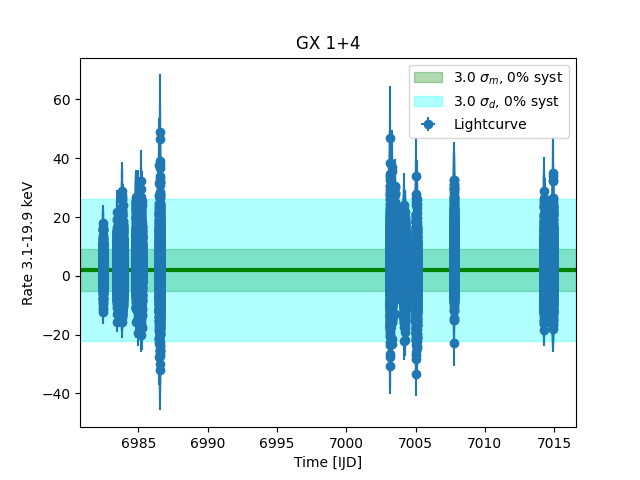

In [23]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
lc = oda_api.plot_tools.OdaLightCurve(combined_data)
_=lc.show(source_name, ng_sig_limit=3.0, find_excesses=True)


## This writes the light curve as a fits file

In [24]:
lc.write_fits(source_name)

('./JMX1_lc_GX_1+4.fits', 58526.424768534154, 58558.94444446016, -1)

## We extact spectral products for JEMX1

In [25]:
par_dict = {
    "DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"api": "True",
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_spectrum",
"product_type": "Real",
"selected_catalog": catalog_string,
"token": token,
}


In [26]:
j1_spec = disp.get_product(**par_dict)

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/oda_api/api.py:922: UserWarning: 
----------------------------------------------------------------------------
the parameter: api   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'jemx_num', 'E1_keV', 'E2_keV']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2021-12-08 17:12:01), please wait fo

## If no source is given, one can see the spectra avalable

In [27]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(j1_spec)
spec.show()

------------------------------
src_name : 1E 1740.7-2942
product : jemx_spectrum
------------------------------
------------------------------
name: 
meta_data dict_keys(['src_name', 'product'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: JMX1-PHA1-SPE
------------------------------
src_name : 1E 1740.7-2942
product : jemx_arf
------------------------------
------------------------------
name: 
meta_data dict_keys(['src_name', 'product'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: SPECRESP
------------------------------
src_name : 1E 1740.7-2942
product : jemx_rmf
------------------------------
------------------------------
name: 
meta_data dict_keys(['src_name', 'product'])
number of data units 6
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: GROUPING
data uniti 2 ,name: SPECRESP MATRIX
data uniti 3 ,name: EBOUNDS
data uniti 4 ,name: JMX

<IPython.core.display.Javascript object>


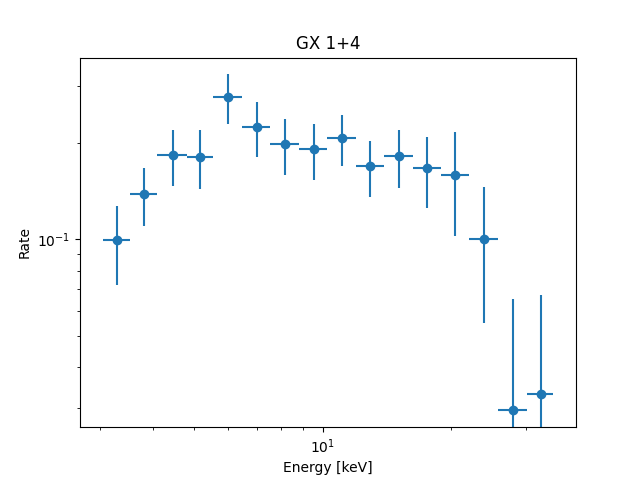

In [28]:
_=spec.show(source_name)

## We extact spectral products for ISGRI

In [29]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_spectrum",
"token": token,
    "selected_catalog": catalog_string
}


In [30]:
isgri_spec = disp.get_product(**par_dict)

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2021-12-08 17:12:30), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: E98AW76ZNB1Z0YGI job: af34b8da505f6abb

... query status prepared => done
... assigned job id: af34b8da505f6abb
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


## This plots the spectra, it is possible to set limits for the energy range

<IPython.core.display.Javascript object>


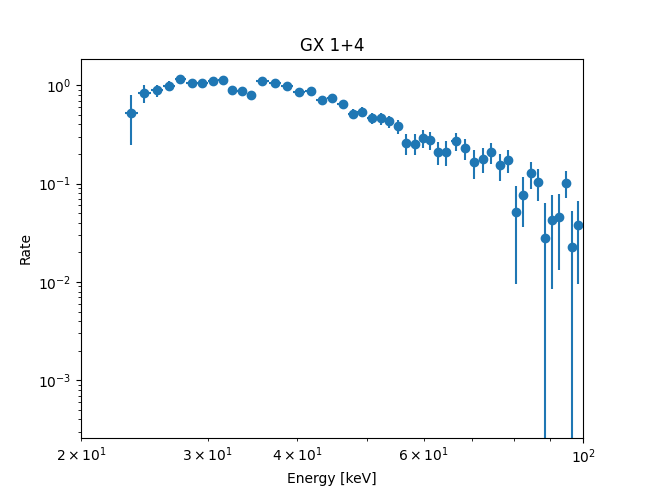

In [31]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
_ = spec.show(source_name, xlim=[20,100])

## This saves spectrum arf and response in a way to be used with xspec 
- systematic fraction adds a systematic fraction to the spectrum
- grouping performs a grouping on the spectrum the argument is [minimum_energy, maximum_energy, bins]
    - bins is the number of bin spaced logarithmically if negative, linearly if positive 

In [32]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
spec.write_fits(source_name, systematic_fraction=0.01, grouping=[30,150,-20])

Saving spectrum ./IBIS_spectrum_GX_1p4.fits with rmf ./IBIS_rmf_GX_1p4.fits and arf ./IBIS_arf_GX_1p4.fits
Geometric grouping with step 1.084


('./IBIS_spectrum_GX_1p4.fits',
 58526.44871680214,
 58566.35018981625,
 24718.52691800761)